# Twitter Author Attribution

Developed by Andrew John (mailto:reachandrewjohn@gmail.com)

#### Problem Brief
The training data set includes tweets from 10 famous people.
The task is to predict which author tweeted the tweet.

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
import string
import time
import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, 
                             mean_squared_error, log_loss, precision_recall_curve, classification_report, 
                             precision_recall_fscore_support)
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.externals import joblib 
import scikitplot as skplt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

import warnings
warnings.filterwarnings("ignore")

##### Natural Language Processing downloads (To be run once)

In [2]:
#Downloads

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

### Data loading

In [24]:
# Load training data 
raw_train_data = pd.read_csv("train_set.csv", encoding="utf8", lineterminator='\n')

In [25]:
# Load test data 
raw_test_data = pd.read_csv("test_set.csv", encoding="utf8", lineterminator='\n')

### Preprocessing

An initial check was done to remove the retweets from the data, because retweets donot convey the original language of the authors. It was found that none of the training and test dataset had retweets, as conveyed by the is_retweet flag

##### Removing URLs
URLs, more often than not, contain alphabets and numbers that are not organised text, but contain gibberish like www.loremipsum.com/asdoepcknru22 (illustrative), hence aren't useful for NLP on the tweet

In [ ]:
#Remove URLS
data = raw_train_data
data['tweet'] =  data['tweet'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

##### Removing certain special characters
Special characters apart from common punctuation symbols (.?!,), hashtags (#) and mentions (@) are removed. # and @ will be useful identification for their significance in the Twitter world and hence are kept without removing

In [ ]:
#Remove special characters
data['tweet'] =  data['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z\s\w.?!,#@]+', '', str(x)))

##### Removing numbers

In [ ]:
#Remove numbers
data['tweet'] =  data['tweet'].apply(lambda x: re.sub('[0-9]+', '', str(x)))

##### Removing stopwords
All the common words are removed using the stopwords library from NLTK

In [ ]:
#Stopword removal
stop = stopwords.words('english')
data.tweet = data.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

##### Tokenizing
A list of words and special characters are made out of the string to break the text down to smaller tokens

In [ ]:
#Tokenize

data['tweet_tokenized'] = data.tweet.apply(lambda x: word_tokenize(x))

##### Lemmatization
Each of the tokens in the tweet are reduced to its base lemma. Lemmatization is preferred over stemming because it converts the word into its root word, rather than just stripping the suffices.
It makes use of the vocabulary and does a morphological analysis to obtain the root word

In [5]:
# Lemmatization

lemmatizer = WordNetLemmatizer()
data['tweet_lemmatized'] = data.tweet_tokenized.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

### Feature Extraction
From the bag-of-words model we can build features to be used by a classifier, here we assume that each word is a feature that can either be True or False. For each word in a sentence we associate True, if a word is missing, that would be the same as assigning False.

In [6]:
#Bag of words - Unigram frequency - feature extraction

data['tweet_lemmatized'] = data.tweet_lemmatized.apply(lambda x: ' '.join(x))

cv = CountVectorizer(lowercase=True, ngram_range = (1,1), analyzer = "word")
data_bow = cv.fit_transform(data['tweet_lemmatized'])

##### Splitting data for validation

In [7]:
#Split data into train and test

xtrain, xtest, ytrain, ytest = train_test_split (data_bow.toarray(),data['author'],test_size=0.3, random_state=1000)

## Text Classification Model

#### Multinomial Naive Bayes Classifier
As a baseline model, the Naive Bayes Classifier is a favorite for text classification and based on the results of the model we can decide which direction to take, in terms of the algorithm

In [8]:
print( "Training the multinomial Naive Bayes Classifier")

NB = MultinomialNB() 

# This may take a few minutes to run
NB_clf = NB.fit(data_bow, data['author'])

Training the multinomial Naive Bayes Classifier


In [10]:
prob_test  = NB_clf.predict_proba(xtest)
prob_train = NB_clf.predict_proba(xtrain)

pred_test  = NB_clf.predict(xtest)
pred_train = NB_clf.predict(xtrain)

In [11]:
#Calculate train and test accuracy
train_acc = accuracy_score(ytrain, pred_train)
test_acc  = accuracy_score(ytest, pred_test)
print ("Train Accuracy :: ", train_acc)
print ("Test Accuracy :: ", test_acc)

Train Accuracy ::  0.8566054027383743
Test Accuracy ::  0.8545323741007195


###### A very healthy accuracy of 85% is achieved by the Naive Bayes Model, and given our ballpark goal of 75-85% accuracy, I have decided to spend more time on the reporting aspects of the model by creating a webapp instead of spending all the time in finetuning for more accuracy. However, further deep dives can be done to understand the model results


 Confusion matrix: 



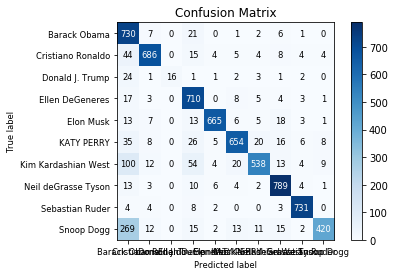

In [12]:
print ("\n Confusion matrix: \n")
skplt.metrics.plot_confusion_matrix(ytest, pred_test, title="Confusion Matrix",
                text_fontsize='small')
plt.show()

In [13]:
#Calculate classification model evaluation metrics like precision, recall, f1 score
report = classification_report(ytest, pred_test)
precision,recall,fscore,support = precision_recall_fscore_support(ytest,pred_test,average='weighted')
print("\n Classification report (weighted average across classes) ::\n", classification_report(ytest, pred_test))


 Classification report (weighted average across classes) ::
                      precision    recall  f1-score   support

       Barack Obama       0.58      0.95      0.72       768
  Cristiano Ronaldo       0.92      0.89      0.90       774
    Donald J. Trump       1.00      0.31      0.48        51
    Ellen DeGeneres       0.81      0.95      0.87       751
          Elon Musk       0.97      0.91      0.94       731
         KATY PERRY       0.92      0.84      0.88       778
Kim Kardashian West       0.91      0.71      0.80       754
Neil deGrasse Tyson       0.90      0.95      0.93       832
    Sebastian Ruder       0.96      0.97      0.97       752
         Snoop Dogg       0.95      0.55      0.70       759

           accuracy                           0.85      6950
          macro avg       0.89      0.80      0.82      6950
       weighted avg       0.88      0.85      0.85      6950



One stark outlier that can be noticed is the poor mapping of Donald Trump's tweets. This can be attributed to the very minimal set of available tweets for him in the training dataset

### Test data predictions
The test data needs to be preprocessed, so that the model can be run on the tweets exactly as the ones done in the training data

In [14]:
#Remove URLS
data_test = raw_test_data
data_test['tweet'] =  data_test['tweet'].apply(lambda x: re.sub(r'http\S+', '', str(x)))

#Remove special characters
data_test['tweet'] =  data_test['tweet'].apply(lambda x: re.sub(r'[^a-zA-Z\s\w.?!,#@]+', '', str(x)))

#Remove numbers
data_test['tweet'] =  data_test['tweet'].apply(lambda x: re.sub('[0-9]+', '', str(x)))

#Stopword removal
stop = stopwords.words('english')
data_test.tweet = data_test.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Tokenize
# NLTK package’s word_tokenize function [10], which results in a list of words and punctuation. 

data_test['tweet_tokenized'] = data_test.tweet.apply(lambda x: word_tokenize(x))

# Lemmatization
# using NLTK’s WordNetLemmatizer to reduce each token to its base lemma

lemmatizer = WordNetLemmatizer()
data_test['tweet_lemmatized'] = data_test.tweet_tokenized.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

For feature extraction, the same object as the CountVectorizer used for the training data needs to be used, else the number of features extracted will vary. Hence, we get the feature names from the older object and use the same for test data

In [15]:
#Bag of words - Unigram frequency - feature extraction

data_test['tweet_lemmatized'] = data_test.tweet_lemmatized.apply(lambda x: ' '.join(x))

cv_test = CountVectorizer(vocabulary=cv.get_feature_names(),lowercase=True, ngram_range = (1,1), analyzer = "word")
data_test_bow = cv_test.fit_transform(data_test['tweet_lemmatized'])

In [18]:
predictions = NB_clf.predict(data_test_bow)

In [19]:
predictions

array(['KATY PERRY', 'Barack Obama', 'Barack Obama', ..., 'Barack Obama',
       'Snoop Dogg', 'Kim Kardashian West'], dtype='<U19')

##### Saving the predicted results

In [26]:
# Creating a dataframe with the non-processed tweets and predictions 
submission = pd.DataFrame({'Tweet':raw_test_data['tweet'],'Author':predictions})

#Visualize the first 5 rows
submission.head()

,Tweet,Author
0,Just got this photo... seems like everything i...,KATY PERRY
1,"In Arizona, a group of @OFA fellows have becom...",Barack Obama
2,"""We shouldn't have to choose between rewarding...",Barack Obama
3,west coast we on! #JokersWild https://t.co/8KG...,Snoop Dogg
4,ICYMI: Read about the historic #ParisAgreement...,Barack Obama


In [27]:
#Convert DataFrame to a csv file that can be uploaded
#This is saved in the same directory as your notebook
filename = 'tweets_testdata_predictions.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: tweets_testdata_predictions.csv


### Summary

Have created a deployment pipeline to serve the predictions with Flask on a ReactJS based webapp. Attached below is the screenshot of it. The webapp can take tweets as the input, and can give out the prediction at the click of a button in the same screen.

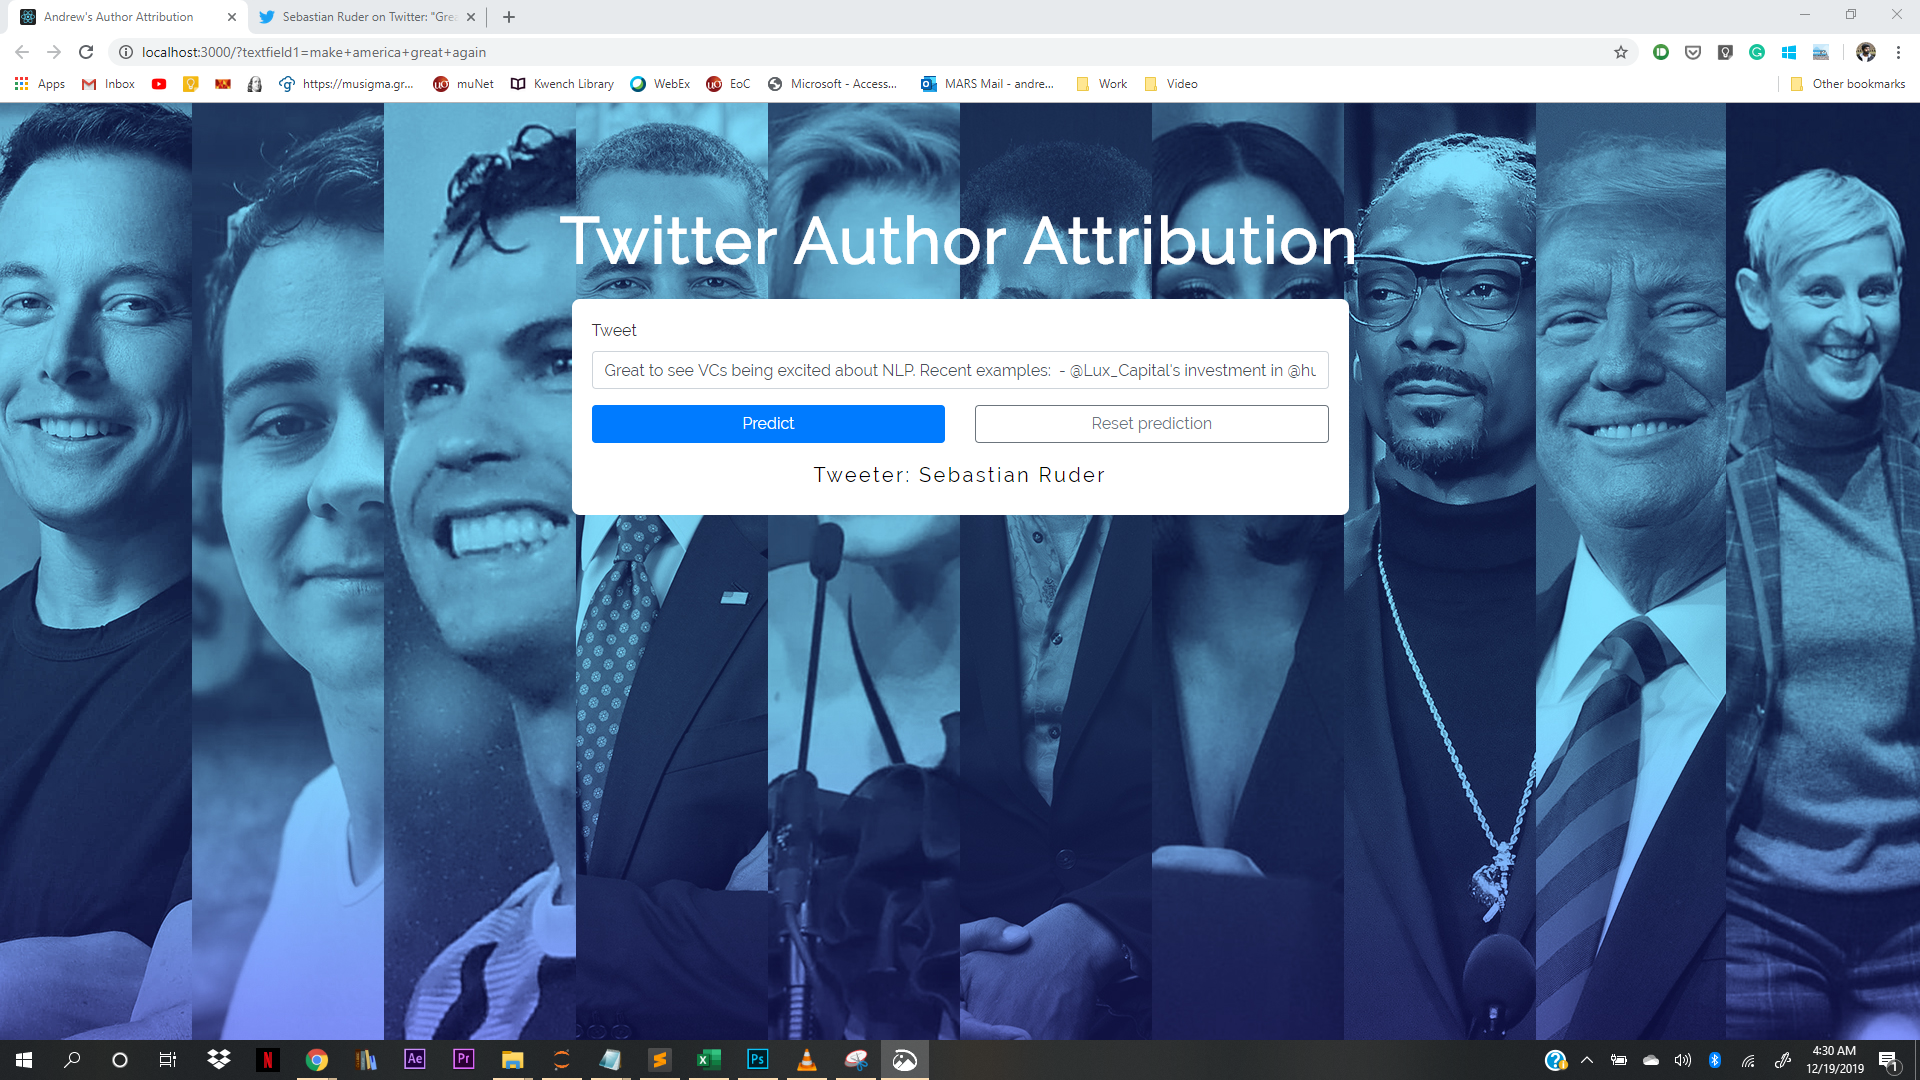

In [29]:
from IPython.display import Image
Image("WebApp_Screenshot_Andrew.png")